# PyALE with Scaled Features
In this notebook is an example of one workaround to use the original values of a scaled feature in the ALE plots generated by PyALE.

The idea is to map the axis labels to the unscaled value by reversing the scaling operation.

The workaround will be implemented below once for a custom scaler and once for an sklearn scaler

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from PyALE import ale

In [2]:
class CustomScaler():
    def __init__(self, feat_raw):
        self.max_raw = max(feat_raw)
        self.min_raw = min(feat_raw)
        
    ## A function to scale  a feature
    def scale_feat(self, x):
        scaled = (x - self.min_raw)/(self.max_raw - self.min_raw)
        return scaled

    ## A function to reverse the scaling (or map the scaled value to the original one)
    def unscale_feat(self, scaled):
        raw = scaled * (self.max_raw - self.min_raw) + self.min_raw
        return raw

## Prepare Data and Train Model

In [3]:
## get the raw diamond data (from R's ggplot2)
dat_diamonds = pd.read_csv(
  "https://raw.githubusercontent.com/tidyverse/ggplot2/master/data-raw/diamonds.csv"
)
X_raw = dat_diamonds.loc[:, ~dat_diamonds.columns.str.contains("price")].copy()

In [4]:
features = ['carat', 'depth', 'table', 'x', 'y', 'z']
X = X_raw.copy()[features]
y = dat_diamonds["price"].copy()

### Scaling

In [5]:
## scale the feature table with the custom scaler
cus_scaler = CustomScaler(X["table"])
X["table_scaled"] = cus_scaler.scale_feat(X["table"])

In [6]:
## scale the feature depth with the sklearn scaler
skl_scaler = MinMaxScaler(feature_range=(-1, 1))
skl_scaler.fit(X["depth"].values.reshape(-1, 1))
X["depth_scaled"] = skl_scaler.transform(X["depth"].values.reshape(-1, 1))

In [7]:
## update features
features.pop(features.index("table"))
features.append("table_scaled")

features.pop(features.index("depth"))
features.append("depth_scaled")

### Training

In [8]:
## train model
model = RandomForestRegressor(random_state=1345)
model.fit(X[features], y)

RandomForestRegressor(random_state=1345)

## Generate ALE plots

### For the feature "table" (custom scaler)

PyALE._ALE_generic:INFO: Continuous feature detected.


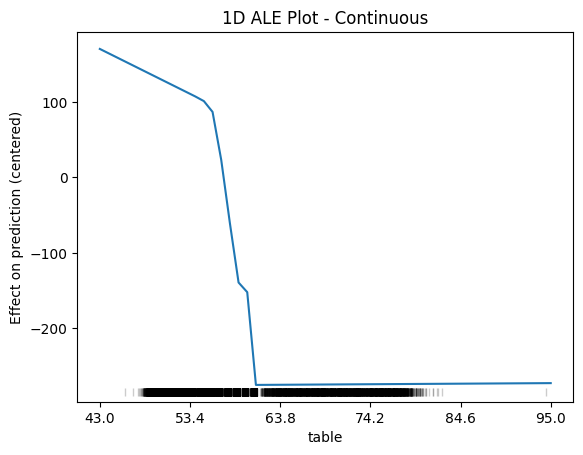

In [9]:
## get ALE plot
fig, ax = plt.subplots()
ale_eff = ale(
    X=X[features], model=model, feature=["table_scaled"], grid_size=20, include_CI=False, fig=fig, ax=ax
)
# re-labeling the x axis to use the unscaled values
# the below line also works, but generates a UserWarning (Workaround taken from https://stackoverflow.com/a/63755285/4905565)
# ax.set_xticklabels([scaler.unscale_feat(lab.get_position()[0]).round(2) for lab in ax.get_xticklabels()])
ticks_loc = ax.get_xticks().tolist()
ax.xaxis.set_major_locator(ticker.FixedLocator(ticks_loc))
ax.set_xticklabels([round(cus_scaler.unscale_feat(x), 2) for x in ticks_loc])
ax.set_xlabel("table")
plt.show()

### For the feature "depth" (sklearn scaler)

PyALE._ALE_generic:INFO: Continuous feature detected.


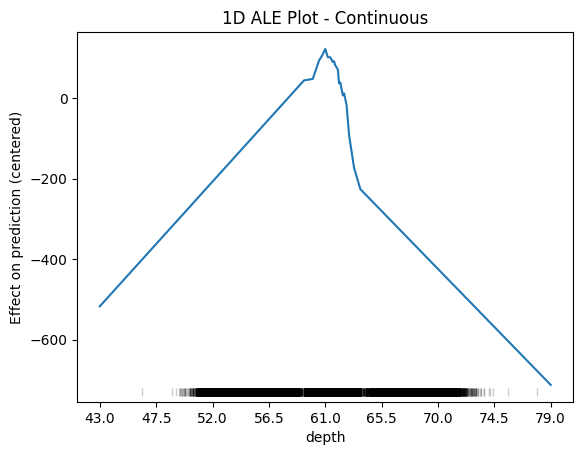

In [10]:
## get ALE plot
fig, ax = plt.subplots()
ale_eff = ale(
    X=X[features], model=model, feature=["depth_scaled"], grid_size=20, include_CI=False, fig=fig, ax=ax
)
# re-labeling the x axis to use the unscaled values
ticks_loc = ax.get_xticks().tolist()
ax.xaxis.set_major_locator(ticker.FixedLocator(ticks_loc))
ax.set_xticklabels(skl_scaler.inverse_transform([ticks_loc]).round(2)[0])
ax.set_xlabel("depth")
plt.show()